In [3]:

import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau



In [1]:
import os
import zipfile
from pathlib import Path
from google.colab import files

# upload the kaggle.json file
files.upload()

# create the kaggle.json file and download data
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c open-problems-single-cell-perturbations

# unzip data
local_zip = '/content/open-problems-single-cell-perturbations.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()


Saving kaggle.json to kaggle.json
100% 3.83G/3.83G [00:46<00:00, 108MB/s]
100% 3.83G/3.83G [00:46<00:00, 89.1MB/s]


In [4]:
#Read the data into a pandas data frame
df = pd.read_parquet("de_train.parquet")

In [5]:
!pip install RDKit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 51.7 MB/s eta 0:00:00


In [6]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

In [7]:
def count_substructure_occurrences(target_smiles, query_smiles):
    try:
        # Convert SMILES to RDKit molecules
        target_mol = Chem.MolFromSmiles(target_smiles)
        query_mol = Chem.MolFromSmiles(query_smiles)

        # Check if the molecules are valid
        if target_mol is None or query_mol is None:
            print("Error: Invalid SMILES.")
            return None

        # Use SubstructMatch to find occurrences
        occurrences = target_mol.GetSubstructMatches(query_mol)

        return len(occurrences)
    except Exception as e:
        print(f"Error: {e}")
        return None

In [8]:
# Identifies functional groups in each compound
functional_groups  = ["O", "C=O", "N", "C(=O)N", "C(=O)O", "N=O", "S", "P([O])([O])", "S(=O)([O])([O])", "C=C", "C#C", "c1ccccc1", "F", "Cl", "Br", "I", "C" ]
functional_column_names = [(i, 'int') for i in functional_groups]
SMILES = df["SMILES"].tolist()

functional_groups_block = [[count_substructure_occurrences(i,j) for j in functional_groups ] for i in SMILES]
functional_group_df = pd.DataFrame(functional_groups_block, columns=[name for name, _ in functional_column_names])
functional_group_df = functional_group_df.astype("float64")


In [10]:
#normalizes data between 0 and 1
#returns normalized data and the factors used to normalzie
def normalize(df):
    min = df.min()
    max=df.max()
    df_normalized = (df - min) / (max-min)
    return df_normalized, min.reset_index(drop=True), max.reset_index(drop=True)


#unnormalize
def unnormalize(normalized_df, min, max):
    return min + normalized_df*(max-min)

In [11]:
############################DATA PREP###############################



####One hot incodes inputs####

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
cells = df["cell_type"].values.reshape(-1, 1)
hot_cells = encoder.fit_transform(cells)
cell_mapping = encoder.categories_[0]

compounds = df['sm_name'].values.reshape(-1, 1)
hot_compounds = encoder.fit_transform(compounds)
compound_mapping = encoder.categories_[0]

#Puts together inputs
hot_encoded = np.hstack((hot_cells, hot_compounds))
hot_encoded_df = pd.DataFrame(data = hot_encoded)
inputs_df = pd.concat([hot_encoded_df, functional_group_df], axis=1)

####Normalizes Outputs####

outputs = df.loc[:, 'A1BG':'ZZEF1']
outputs_norm_df, norm_min, norm_max = normalize(outputs)


####Puts Inputs and Outputs Together####
prepped_df = pd.concat([inputs_df, outputs_norm_df], axis=1)





In [12]:
#Break into training and validation and split inputs from outputs
val, train = train_test_split(prepped_df, train_size=.2, random_state=3)
trainIn_df = train.loc[:, 0:"C"]
trainOut_df = train.loc[:, 'A1BG':'ZZEF1']
valIn_df = val.loc[:,0:"C"]
valOut_df = val.loc[:, 'A1BG':'ZZEF1']

#Transforms data frames into tensors
trainIn_t = torch.tensor(trainIn_df.values).cuda()
trainOut_t = torch.tensor(trainOut_df.values).cuda()
valIn_t = torch.tensor(valIn_df.values).cuda()
valOut_t = torch.tensor(valOut_df.values).cuda()




In [13]:

#layers is a list of any length (at least 3) of the form [input, hidden1, hidden 2,....., output]

def build_model(layers, dropout_p=0.5):
    class DynamicNet(nn.Module):
        def __init__(self, layer_sizes, dropout_p):
            super(DynamicNet, self).__init__()
            self.layers = nn.ModuleList()
            for i in range(len(layer_sizes) - 2):
                self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(dropout_p))
            self.layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
            self.act_output = nn.Sigmoid()

        def forward(self, x):
            for layer in self.layers:
                x = layer(x)
            x = self.act_output(x)
            return x

    model = DynamicNet(layers, dropout_p)
    model.double()
    return model


In [14]:

#training loop

def train(epoch_number, batch_size, layers):
    model = build_model(layers)

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    # Initialize the plateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

    epoch_test_losses = []
    epoch_val_losses = []



    for epoch in range(epoch_number):
        batch_losses = []
        for i in range(0, len(trainIn_t), batch_size):
            Xbatch = trainIn_t[i:i+batch_size]
            ybatch = trainOut_t[i:i+batch_size]
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        # After each epoch, get the mean loss for the train and validation data.
        epoch_test_loss = np.mean(batch_losses)
        epoch_test_losses.append(epoch_test_loss)

        #model.eval()
        with torch.no_grad():
            y_pred = model(valIn_t)
            epoch_val_loss = loss_fn(y_pred,valOut_t)
        epoch_val_losses.append(epoch_val_loss)
        scheduler.step(epoch_val_loss)


        print(f"Epoch {epoch}, Training Loss: {epoch_test_loss}, Validation Loss: {epoch_val_loss}")

    return epoch_test_losses, epoch_val_losses, model



Epoch 0, Training Loss: 0.6303253600908397, Validation Loss: 0.5520840295974381
Epoch 1, Training Loss: 0.5433313187552654, Validation Loss: 0.5399344228100257
Epoch 2, Training Loss: 0.5305288551231531, Validation Loss: 0.5322470740221988
Epoch 3, Training Loss: 0.5273431758557298, Validation Loss: 0.530986895217156
Epoch 4, Training Loss: 0.5263189419521059, Validation Loss: 0.5296631039972259
Epoch 5, Training Loss: 0.5261992632513203, Validation Loss: 0.5303960775973706
Epoch 6, Training Loss: 0.5264635242938852, Validation Loss: 0.5295151233848406
Epoch 7, Training Loss: 0.5257929005951548, Validation Loss: 0.5301460313948324
Epoch 8, Training Loss: 0.5259301722691355, Validation Loss: 0.5291013897493249
Epoch 9, Training Loss: 0.5256691721147219, Validation Loss: 0.5294562454907157
Epoch 10, Training Loss: 0.5258001813479195, Validation Loss: 0.5294412918987612
Epoch 11, Training Loss: 0.5254740749056398, Validation Loss: 0.5299429749999751
Epoch 12, Training Loss: 0.525938034876

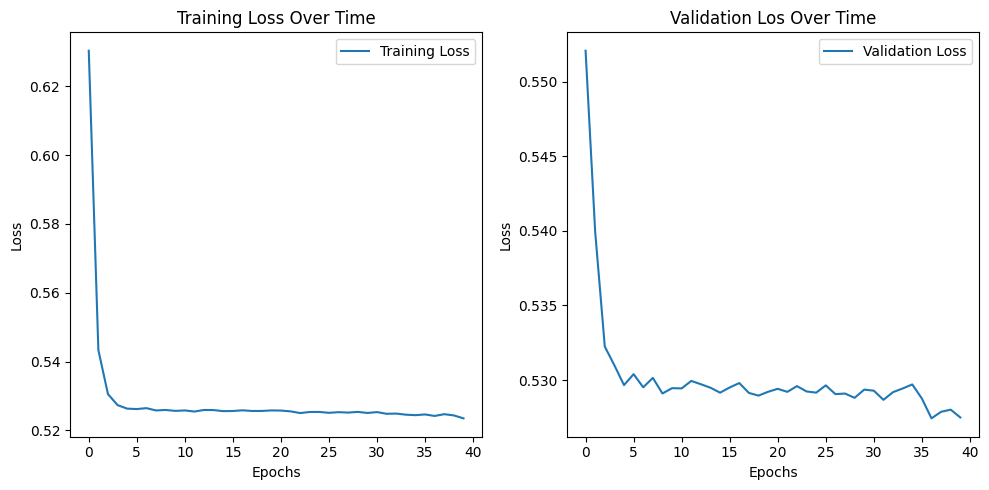

In [15]:

# Call your train(epochs, batch size, layers) function
train_losses, test_losses, model = train(40, 45, [169, 320, 624, 248, 824, 1056, 6000, 18211])

# Now plot the loss over epochs
plt.figure(figsize=(10, 5))

# Plotting the training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()


# Plotting the deviation over epochs
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in test_losses], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Los Over Time')
plt.legend()

plt.tight_layout()
plt.show()



In [20]:
def hot_encode(cell,compound):
    cell_vec = np.zeros(cell_mapping.size)
    cell_dict = {value: index for index, value in enumerate(cell_mapping)}

    compound_vec = np.zeros(compound_mapping.size)
    compound_dict = {value: index for index, value in enumerate(compound_mapping)}

    sm_names = df["sm_name"].tolist()
    functional_group_dict= dict(zip(sm_names, functional_groups_block))


    cell_vec[cell_dict[cell]]=1
    compound_vec[compound_dict[compound]]=1
    functional_group_vec = np.array(functional_group_dict[compound])
    vector = np.concatenate((cell_vec, compound_vec, functional_group_vec), axis = 0)
    tensor = torch.from_numpy(vector)
    return tensor


In [21]:
def get_expression(cell_type, compound_name):
    model.eval()
    tensor = model(hot_encode(cell_type,compound_name).cuda())
    np_array = tensor.detach().cpu().numpy()
    df = pd.DataFrame(np_array)
    return unnormalize(df[0],norm_min,norm_max)







In [22]:
# Read the sample submission and test set ID map
sample_submission = pd.read_csv("sample_submission.csv")
testDf = pd.read_csv("id_map.csv")

# Initialize an empty list to collect the predicted values
predicted_values = []

# Loop through the test set to get the predicted values
for idx, row in testDf.iterrows():
    cell_type = row['cell_type']
    sm_name = row['sm_name']

    # Call your get_expression method here
    expression_values = get_expression(cell_type, sm_name)

    # Append the values to the list
    predicted_values.append(expression_values)

# Convert the list of predicted values to a numpy array
predicted_values_array = np.array(predicted_values)

# Replace the values in the sample submission DataFrame
sample_submission.iloc[:, 1:] = predicted_values_array

# Save the DataFrame to a new CSV file
sample_submission.to_csv("my_submission.csv", index=False)

